<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/1_Training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SealNN training notebook
This notebook contains the image processing of MAXAR satellite images and the training of the deep learning.
The input requires the satellite image as .tif and seal annotations as .shp. The output is a the SealNN model that will be used in detecting seals in the following post-processing notebook.

###Import libraries

Connect to Google colab or connect to a local drive

In [1]:
## Set up working directory and project directories

def in_colab():
    """
    Check if the code is running in Google Colab.

    Args:
    None

    Returns:
    - bool: True if the code is running in Google Colab, False otherwise.
    """

    try:
        import google.colab
        return True
    except ImportError:
        return False

import os

## Set working directory to Google Drive or Local based on usage
if in_colab():
    ## GOOGLE COLAB USERS ONLY
    ## Mount Google Drive for data retrieval
    ## This cell assumes that you have copied the "TheNavySeals" GitHub repository into your root drive folder
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/TheNavySeals/'

    !pip install torch torchvision segmentation-models-pytorch tifffile tabulate rasterio -q
else:
    ## LOCAL USERS ONLY
    ## Change the path to your project directory (where you cloned the GitHub repository)
    ## If you are running local, make sure you have set up the environment according to the readme in GitHub
    print("Running Locally")
    os.chdir('F:\WUR\Git_ACT\TheNavySeals')
    project_path = ''

Running in Google Colab
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.3 MB/s eta 0:00:00


###Define paths for both local and Google Colab

In [29]:
panchromatic_path = os.path.join(project_path, 'data/1_preprocessing/1ps_image')
os.makedirs(panchromatic_path, exist_ok=True)
panchromatic = os.path.join(panchromatic_path, '22MAR25134903-P3DS-014983717010_01_P001.TIF') #Change to your image name

shapefile_path  = os.path.join(project_path, 'data/1_preprocessing/1ps_shapefile')
os.makedirs(shapefile_path, exist_ok=True)

csv_path = os.path.join(project_path, 'data/1_preprocessing/1e_raster_statistics')
os.makedirs(csv_path, exist_ok=True)
csv = os.path.join(csv_path, '1e_raster_statistics.csv')

model_output_path  = os.path.join(project_path, 'data/2_deep_learning/2b_output_model/')
os.makedirs(model_output_path, exist_ok=True)

if in_colab():
    panchromatic_reduced_path = os.path.join(project_path, '/content/data/1_preprocessing/1a_reduced_image/')
    os.makedirs(panchromatic_reduced_path, exist_ok=True)
    panchromatic_reduced = os.path.join(panchromatic_reduced_path, '1a_panchromatic_reduced.TIF')

    panchromatic_parts_path = os.path.join(project_path, '/content/data/1_preprocessing/1b_panchromatic_parts')
    os.makedirs(panchromatic_parts_path, exist_ok=True)

    mask_path = os.path.join(project_path, '/content/data/1_preprocessing/1c_raster_mask')
    os.makedirs(mask_path, exist_ok=True)
    mask = os.path.join(mask_path, '1c_raster_mask.TIF')

    mask_parts_path = os.path.join(project_path, '/content/data/1_preprocessing/1d_mask_parts')
    os.makedirs(mask_parts_path, exist_ok=True)

    output_path_images = os.path.join(project_path, '/content/data/1_preprocessing/1f_divided_images')
    os.makedirs(output_path_images, exist_ok=True)

    output_path_masks = os.path.join(project_path, '/content/data/1_preprocessing/1g_divided_masks')
    os.makedirs(output_path_masks, exist_ok=True)

else:
    panchromatic_reduced_path = os.path.join(project_path, 'data/1_preprocessing/1a_reduced_image/')
    os.makedirs(panchromatic_reduced_path, exist_ok=True)
    panchromatic_reduced = os.path.join(panchromatic_reduced_path, '1a_panchromatic_reduced.TIF')

    panchromatic_parts_path = os.path.join(project_path, 'data/1_preprocessing/1b_panchromatic_parts')
    os.makedirs(panchromatic_parts_path, exist_ok=True)

    mask_path = os.path.join(project_path, 'data/1_preprocessing/1c_raster_mask')
    os.makedirs(mask_path, exist_ok=True)
    mask = os.path.join(mask_path, '1c_raster_mask.TIF')

    mask_parts_path = os.path.join(project_path, 'data/1_preprocessing/1d_mask_parts')
    os.makedirs(mask_parts_path, exist_ok=True)

    output_path_images = os.path.join(project_path, 'data/1_preprocessing/1f_divided_images')
    os.makedirs(output_path_images, exist_ok=True)

    output_path_masks = os.path.join(project_path, 'data/1_preprocessing/1g_divided_masks')
    os.makedirs(output_path_masks, exist_ok=True)

# Define paths for deep learning input
training_set_dl = os.path.join(project_path, 'data/2_deep_learning/2a_training_set')
os.makedirs(training_set_dl, exist_ok=True)

# Create directories
for path in [training_set_dl]:
    os.makedirs(os.path.join(path, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(path, 'train', 'masks'), exist_ok=True)
    os.makedirs(os.path.join(path, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(path, 'val', 'masks'), exist_ok=True)
    os.makedirs(os.path.join(path, 'test', 'images'), exist_ok=True)
    os.makedirs(os.path.join(path, 'test', 'masks'), exist_ok=True)

train_data_path = os.path.join(project_path, "data/2_deep_learning/2a_training_set/train")
val_data_path = os.path.join(project_path, "data/2_deep_learning/2a_training_set/val")
test_data_path = os.path.join(project_path, "data/2_deep_learning/2a_training_set/test")

Import required packages and libraries

In [2]:
## Import libraries for image processing
from os import path
import os.path
from osgeo import gdal
import rasterio
# from rasterio import windows
# from rasterio.windows import Window
# from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize, geometry_mask
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, box, Polygon
# from shapely.ops import cascaded_union
import numpy as np
import shutil
# from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from glob import glob

## Import libraries for training
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import torchvision
# from torchvision.transforms import v2 as transforms
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tifffile
# from PIL import Image
import time
from tabulate import tabulate
import random

### Functions for image processing

In [3]:
def reduce_radiometric_resolution(input_path, output_path, input_res=11):
    """
    Reduces the radiometric resolution of the input raster and save the output raster.

    Args:
    - input_path (string): Path to the input raster.
    - output_path (string): Path to the output raster.
    - input_res (int): Radiometric resolution of the input raster in bits.

    Returns:
    None
    """

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with rasterio.open(input_path) as src:
        # Read the number of bands
        num_bands = src.count

        # Initialize an array to store the scaled bands
        scaled_arrays = []

        for band in range(1, num_bands + 1):
            # Read the image band as a numpy array
            image_array = src.read(band, masked=True)

            # Rescale the pixel values to fit within 8-bit range (0-255)
            scaled_array = (image_array / (2**input_res - 1) * 255).astype(np.uint8)

            # Append the scaled array to the list
            scaled_arrays.append(scaled_array)

        # Stack the scaled arrays along the first axis to create a 3D array
        scaled_arrays = np.stack(scaled_arrays, axis=0)

        # Create a new raster profile with 8-bit pixel depth
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=num_bands)

        # Write the scaled arrays to a new raster file
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(scaled_arrays)



def mosaic_rasters(input_folder, output_path):
    """
    Mosaics multiple multiband rasters together.

    Args:
    - input_folder (string): Path to the folder containing the rasters.
    - output_path (string): Path to the output raster.

    Returns:
    None
    """

    # List to hold the file paths of the rasters to be merged
    input_files = []

    # Loop through the folder and add all .tif files to the list
    for file_name in os.listdir(input_folder):
        print(file_name)
        if file_name.endswith('.TIF'):
            input_files.append(os.path.join(input_folder, file_name))

    # Check if we have any input files
    if not input_files:
        raise FileNotFoundError("No .tif files found in the specified folder.")

    # Open the input files
    src_files_to_mosaic = []
    for file in input_files:
        src = gdal.Open(file)
        if src:
            src_files_to_mosaic.append(src)
        else:
            print(f"Failed to open {file}")

    # Create a virtual raster from the input files
    vrt = gdal.BuildVRT('temporary.vrt', src_files_to_mosaic)

    # Write the virtual raster to a new file
    gdal.Translate(output_path, vrt)

    # Cleanup
    vrt = None
    for src in src_files_to_mosaic:
        src = None

    print(f"Mosaic raster saved as {output_path}")



def create_polygon_from_pixels(row, col, transform):
    """
    Creates a polygon from raster pixels.

    Args:
    - row (int): The row index of the center pixel.
    - col (int): The column index of the center pixel.
    - transform (tuple): A tuple of 6 elements representing the affine transformation coefficients
                         (a, b, c, d, e, f) which map pixel coordinates (x, y) to geographic coordinates (X, Y):
                         X = a + b * x + c * y
                         Y = d + e * x + f * y

    Returns:
    - Polygon: A polygon representing a 5x5 block of pixels centered around the given pixel.
    """

    # Calculate the coordinates of the top-left corner of the top-left pixel
    top_left_x = transform[0] + (col - 2) * transform[1] + (row - 2) * transform[2]
    top_left_y = transform[3] + (col - 2) * transform[4] + (row - 2) * transform[5]

    # Pixel dimensions
    pixel_width = abs(transform[1])
    pixel_height = abs(transform[5])

    # Calculate the coordinates for the 5x5 block of pixels
    polygon_coords = [
        (top_left_x, top_left_y),
        (top_left_x + 5 * pixel_width, top_left_y),
        (top_left_x + 5 * pixel_width, top_left_y - 5 * pixel_height),
        (top_left_x, top_left_y - 5 * pixel_height),
        (top_left_x, top_left_y)
    ]

    return Polygon(polygon_coords)



def raster_points_to_polygons(raster_path, shapefile_path):
    """
    Converts point geometries in a shapefile to polygons representing 5x5 pixel blocks in a raster.

    Args:
    - raster_path (str): File path to the raster dataset.
    - shapefile_path (str): File path to the shapefile with point geometries.

    Returns:
    geopandas.GeoDataFrame: GeoDataFrame with polygons representing 5x5 pixel blocks centered around points in the shapefile.
    """

    # Read raster data
    raster_dataset = gdal.Open(raster_path)
    raster_geotransform = raster_dataset.GetGeoTransform()

    # Read shapefile
    shapefile_gdf = gpd.read_file(shapefile_path)
    shape_crs = shapefile_gdf.crs

    polygons = []
    for point in shapefile_gdf.geometry:
        # Convert point coordinates to raster coordinates
        x, y = point.x, point.y
        col = int((x - raster_geotransform[0]) / raster_geotransform[1])
        row = int((y - raster_geotransform[3]) / raster_geotransform[5])

        # Create polygon around the pixel and its 24 surrounding pixels
        polygon = create_polygon_from_pixels(row, col, raster_geotransform)
        polygons.append(polygon)

    result_gdf = gpd.GeoDataFrame(geometry=polygons, crs=shape_crs)

    return result_gdf



def mask_raster_with_polygon(input_raster_path, polygons, output_raster_path, value=1):
    """
    Creates a copy of a raster, set all its values to 0, overlay it with a polygon shapefile,
    and set all pixels underneath polygons to a specified value.

    Args:
    - input_raster_path (str): Path to the input raster.
    - polygons (gdf): GeoDataFrame with the polygons of the mask.
    - output_raster_path (str): Path to save the masked raster.
    - value (int, optional): Value to set for pixels underneath polygons. Defaults to 1.

    Returns:
    None
    """

    # Open the input raster for reading
    with rasterio.open(input_raster_path) as src:
        # Read raster data
        raster_data = src.read(1)
        # Get metadata
        meta = src.meta

    # Set all values to 0
    raster_data.fill(0)

    # Create mask from polygons
    mask = geometry_mask(polygons.geometry, out_shape=raster_data.shape, transform=src.transform, invert=True)

    # Set pixels underneath polygons to the specified value
    raster_data[mask] = value

    # Save the masked raster
    with rasterio.open(output_raster_path, 'w', **meta) as dst:
        dst.write(raster_data, 1)



def tile_raster(input_raster_path, part_width, part_height, output_folder):
    """
    Splits a raster into multiple tiles of length part_width and height part_height, and save them in output_folder.

    Args:
    - input_raster_path: path to the input raster.
    - part_width (int): Width of each tile.
    - part_height (int): Height of each tile.
    - output_folder (str): Directory to save the rasters.

    Returns:
    None
    """

    # Open the raster
    dataset = gdal.Open(input_raster_path)

    # Get raster dimensions
    width = dataset.RasterXSize
    height = dataset.RasterYSize

    # Calculate the number of parts
    num_parts_x = width // part_width
    num_parts_y = height // part_height

    # Get the number of bands
    bands = dataset.RasterCount

    # Split the raster and save
    for i in range(num_parts_x):
        for j in range(num_parts_y):
            x_offset = i * part_width
            y_offset = j * part_height

            # Read the split region
            part = dataset.ReadAsArray(x_offset, y_offset, part_width, part_height)

            # Expand dimensions if there's only one band
            if bands == 1:
               part = np.expand_dims(part, axis=0)

            # Create a new GDAL dataset to save the split part
            driver = gdal.GetDriverByName('GTiff')
            output_path = os.path.join(output_folder, f'part_{i}_{j}.tif')
            out_dataset = driver.Create(output_path, part_width, part_height, bands, gdal.GDT_UInt16)

            # Write data to the new dataset
            for band in range(bands):
                out_band = out_dataset.GetRasterBand(band + 1)
                out_band.WriteArray(part[band])

            # Set georeference and projection
            geo_transform = list(dataset.GetGeoTransform())
            geo_transform[0] += x_offset * geo_transform[1]
            geo_transform[3] += y_offset * geo_transform[5]
            out_dataset.SetGeoTransform(tuple(geo_transform))
            out_dataset.SetProjection(dataset.GetProjection())

            # Save and close
            out_dataset.FlushCache()
            del out_dataset

    # Close the original dataset
    del dataset



def contains_zero(input_raster_path):
    """
    Checks if a single band raster has a zero value pixel.

    Args:
    - input_raster_path (str): Path to the input raster.

    Returns:
    - bool: True if the raster contains at least one zero value pixel, False otherwise.
    """

    with rasterio.open(input_raster_path) as src:
        # Read the image as a numpy array
        raster_array = src.read(1)
        # Check if the array contains any zero values
        return (raster_array == 0).any()



def remove_images_with_zero_panchromatic(directory, panchromatic_directory, mask_directory):
    """
    Removes images from a directory if they contain a zero value pixel in their corresponding panchromatic image.
    Also removes corresponding images from the mask directory.

    Args:
    - directory (str): Path to the directory containing the images and masks to validate.
    - panchromatic_directory (str): Path to the directory containing the panchromatic images.
    - mask_directory (str): Path to the directory containing the mask images.

    Returns:
    None
    """

    for filename in os.listdir(directory):
        if filename.endswith(('.tif', '.tiff')):
            file_path = os.path.join(directory, filename)
            panchromatic_path = os.path.join(panchromatic_directory, filename)
            if contains_zero(panchromatic_path):
                os.remove(file_path)
                print(f"Removed image: {file_path}")

                # Remove the mask image with the same name
                mask_path = os.path.join(mask_directory, filename)
                if os.path.exists(mask_path):
                    os.remove(mask_path)
                    print(f"Removed mask: {mask_path}")


                # Remove the pansharpened image with the same name
                panchromatic_path = os.path.join(panchromatic_directory, filename)
                if os.path.exists(panchromatic_path):
                    os.remove(panchromatic_path)
                    print(f"Removed mask: {panchromatic_path}")



def contains_zero(input_raster_path):
    """
    Checks if a single band raster has a zero value pixel.

    Args:
    - input_raster_path (str): Path to the input raster.

    Returns:
    - bool: True if the raster contains at least one zero value pixel, False otherwise.
    """

    with rasterio.open(input_raster_path) as src:
        # Read the image as a numpy array
        raster_array = src.read(1)
        # Check if the array contains any zero values
        return (raster_array == 0).any()



def contains_zero_multiband(image_path):
    """
    Check if an image has a zero value pixel in any of its bands.

    Args:
    - image_path (str): File path to the multiband image file.

    Returns:
    - bool: True if any band in the image contains at least one zero value pixel, False otherwise.
    """

    with rasterio.open(image_path) as src:
        # Iterate through each band
        for band in range(1, src.count + 1):
            # Read the current band as a numpy array
            image_array = src.read(band)
            # Check if the array contains any zero values
            if (image_array == 0).any():
                return True
    return False



def remove_mulraster_with_zero_values(directory):
    """
    Removes raster files from a directory if they contain any zero value pixels.

    Args:
    - directory (str): Path to the directory containing the raster images to validate and potentially remove.

    Returns:
    None
    """

    for filename in os.listdir(directory):
        if filename.endswith(('.tif', '.tiff')):
            file_path = os.path.join(directory, filename)
            if contains_zero_multiband(file_path):
                os.remove(file_path)
                #print(f"Removed raster: {file_path}")



def remove_zero_raster_mask(directory, mask_directory):
    """
    Removes all rasters from a directory that contain a zero value pixel.
    Also removes rasters with the same name from the mask directory.

    Args:
    - directory (str): Path to the directory containing the rasters to validate.
    - mask_directory (str): Name of the folder containing the mask rasters with the same name.

    Returns:
    None
    """

    for filename in os.listdir(directory):
        if filename.endswith(('.tif', '.tiff')):
            file_path = os.path.join(directory, filename)
            if contains_zero(file_path):
                os.remove(file_path)
                # print(f"Removed image: {file_path}")

                # Remove the image with the same name from the similar folder
                mask_path = os.path.join(mask_directory, filename)
                if os.path.exists(mask_path):
                    os.remove(mask_path)
                    # print(f"Removed similar image: {mask_path}")



def update_masks(panchromatic_parts_path, mask_parts_path, threshold_value):
    """
    Updates mask images based on corresponding panchromatic images. Specifically, for each mask,
    all pixels with a value of 1 that correspond to pixels in the panchromatic image with a value above the
    specified threshold are set to 0 in the new mask.

    Args:
    - panchromatic_parts_path (str): The directory path containing the panchromatic images.
    - mask_parts_path (str): The directory path containing the mask images.
    - threshold_value (int): The threshold value for the panchromatic image pixels. Pixels in the mask with a value of 1 and corresponding panchromatic image pixels above this threshold will be set to 0 in the new mask.

    Returns:
    None
    """

    # List all mask files in the specified directory
    mask_files = [f for f in os.listdir(mask_parts_path) if f.endswith('.tif')]

    for mask_file in mask_files:
        # Construct the full file paths for the mask and corresponding panchromatic image
        mask_path = os.path.join(mask_parts_path, mask_file)
        image_path = os.path.join(panchromatic_parts_path, mask_file)

        # Read the panchromatic image
        with rasterio.open(image_path) as img:
            image_data = img.read(1)

        # Read the mask image
        with rasterio.open(mask_path) as mask:
            mask_data = mask.read(1)
            mask_meta = mask.meta

        # Update the mask data based on the condition
        new_mask_data = np.where((mask_data == 1) & (image_data > threshold_value), 0, mask_data)

        # Save the new mask data overwriting the old mask
        with rasterio.open(mask_path, 'w', **mask_meta) as mask:
            mask.write(new_mask_data, 1)



def obtain_statistic(image_path, shapefile_path):
    """
    Counts the points that are within the bounds of an image and calculate the average pixel value.

    Args:
    - image_path (str): Path to the input raster.
    - shapefile_path (str): Path to the shapefile containing points.

    Returns:
    - num_points (int): Number of points within the image bounds.
    - avg_pixel_value (float): Average pixel value of the image.
    """

    with rasterio.open(image_path) as src:
        image_bounds = src.bounds
        image_box = box(image_bounds.left, image_bounds.bottom, image_bounds.right, image_bounds.top)
        # Read the CRS from the image
        image_crs = src.crs
        # Calculate the average pixel value
        image_data = src.read(1)  # Read the first band
        avg_pixel_value = np.mean(image_data)
    shapefile = gpd.read_file(shapefile_path)

    shapefile['within_image'] = shapefile.apply(lambda row: image_box.contains(Point(row.geometry.x, row.geometry.y)), axis=1)
    points_within_image = shapefile[shapefile['within_image']]

    return len(points_within_image), avg_pixel_value



def obtain_statistics(image_dir, shapefile_path, csv_path):
    """
    Computes the statistics based on the obtain_statistic function above. This outputs the number of seals and average pixel value per image to a CSV file.

    Args:
    - image_dir(str): Image directory where the images to calculate for are located.
    - shapefile_path(str): Path to the shapefile containing the points.
    - csv_path(str): Path to the csv to store the results.

    Returns:
    None
    """

    # List to store results
    results = []

    # Iterate through all images in the directory
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            num_points, avg_pixel_value = obtain_statistic(image_path, shapefile_path)
            results.append({'image_name': image_name, 'num_points': num_points, 'avg_pixel_value': avg_pixel_value})
            print(f'appended image {image_name}')
    # Convert results to DataFrame and save as CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(csv_path, index=False)

    print(f"Results saved to {csv_path}")



def organize_images(csv_file, image_folder, output_folder):
    """
    Organises images into subfolders based on the number of seals and average pixel values.

    Args:
    - csv_file (str): Path to the CSV file containing image data.
    - image_folder (str): Directory containing the images.
    - output_folder (str): Directory to save the organized subfolders.

    Returns:
    None
    """

    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Create the main output directories
    no_seals_folder = os.path.join(output_folder, 'no_seals')
    seals_folder = os.path.join(output_folder, 'seals')
    os.makedirs(no_seals_folder, exist_ok=True)
    os.makedirs(seals_folder, exist_ok=True)

    # Create subfolders for 'no_seals'
    ice_folder = os.path.join(no_seals_folder, 'ice')
    water_folder = os.path.join(no_seals_folder, 'water')
    os.makedirs(ice_folder, exist_ok=True)
    os.makedirs(water_folder, exist_ok=True)

    # Process each row in the CSV
    for index, row in df.iterrows():
        image_name = row[0]
        seal_count = row[1]
        avg_pixel_value = row[2]

        # Define the source and destination paths
        src_path = os.path.join(image_folder, image_name)

        # Determine the destination folder based on seal count and pixel value
        if seal_count == 0:
            if avg_pixel_value > 20:
                dst_folder = ice_folder
            else:
                dst_folder = water_folder
        else:
            dst_folder = seals_folder

        # Copy the image to the appropriate folder
        dst_path = os.path.join(dst_folder, image_name)
        shutil.copy(src_path, dst_path)

    print("Images have been organized into subfolders.")



def split_data(input_panchromatic, input_mask, output_path, train_ratio=0.8, val_ratio=0.15, test_ratio=0.05):
    """
    Splits panchromatic images and corresponding masks into training, validation, and test sets based on specified ratios.

    Args:
    - input_panchromatic (str): Path to directory with panchromatic images.
    - input_mask (str): Path to directory with corresponding mask images.
    - output_path (str): Path where split dataset will be saved.
    - train_ratio (float, optional): Ratio of training data (default is 0.8).
    - val_ratio (float, optional): Ratio of validation data (default is 0.15).
    - test_ratio (float, optional): Ratio of test data (default is 0.05).

    Returns:
    None
    """

    assert train_ratio + val_ratio + test_ratio == 1, "The ratios must sum to 1."
    def move_files(files, output_subfolder):
        for file in files:
            filename = os.path.basename(file)
            shutil.copy(file, os.path.join(output_subfolder, 'images', filename))
            mask_file = file.replace(input_panchromatic, input_mask)
            shutil.copy(mask_file, os.path.join(output_subfolder, 'masks', filename))
    # Collect and sort images
    seals_images = sorted(glob(os.path.join(input_panchromatic, 'seals', '*.tif')))
    water_images = sorted(glob(os.path.join(input_panchromatic, 'no_seals', 'water', '*.tif')))
    ice_images = sorted(glob(os.path.join(input_panchromatic, 'no_seals', 'ice', '*.tif')))
    total_seals = len(seals_images)
    half_seals = total_seals // 2

    # Ensure water and ice have enough images
    water_images = water_images[:half_seals]
    ice_images = ice_images[:half_seals]
    train_count = int(train_ratio * total_seals)
    val_count = int(val_ratio * total_seals)
    test_count = total_seals - train_count - val_count

    # Split images
    train_images = seals_images[:train_count] + water_images[:train_count//2] + ice_images[:train_count//2]
    val_images = seals_images[train_count:train_count + val_count] + water_images[train_count//2:train_count//2 + val_count//2] + ice_images[train_count//2:train_count//2 + val_count//2]
    test_images = seals_images[train_count + val_count:] + water_images[train_count//2 + val_count//2:] + ice_images[train_count//2 + val_count//2:]

    move_files(train_images, os.path.join(output_path, 'train'))
    move_files(val_images, os.path.join(output_path, 'val'))
    move_files(test_images, os.path.join(output_path, 'test'))

### Functions for SealNN training

In [4]:
def trans(image, mask):
    """
    Transforms an image and its corresponding mask for use in a machine learning model training.

    Args:
    - image (PIL.Image.Image): Input image to be transformed.
    - mask (PIL.Image.Image): Corresponding mask image to be transformed.

    Returns:
    - torch.Tensor: Transformed image tensor normalized and optionally augmented.
    - torch.Tensor: Transformed mask tensor, possibly augmented to match the image transformation.
    """

    # Convert to tensor
    image = TF.to_tensor(image).float() / 255.0 # get pixel values between 0 and 1 for uint8
    mask = TF.to_tensor(mask).float() # Ensure mask is also in float32

    # Apply horizontal flip with 50% probability
    if random.random() < 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if image.shape[0] != 1:
        image = image[:3, :, :]  # Assumes that first three channels are RGB
        mask = mask.repeat(3, 1, 1)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        image = TF.normalize(image, mean=0.445, std=0.269)

    return image, mask



def denormalize(image_tensor):
    """
    Denormalizes an image tensor back to its original range for visualization purposes.

    Args:
    - image_tensor (torch.Tensor): Input image tensor to be denormalized.

    Returns:
    - torch.Tensor: Denormalized image tensor with pixel values in the original range.
    """

    if image_tensor.shape[0] != 1:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image_tensor.device)
    else:
        mean = torch.tensor([0.5]).view(1, 1, 1).to(image_tensor.device)
        std = torch.tensor([0.5]).view(1, 1, 1).to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    return image_tensor



def segmentation_dataset(data_path, transform=None):
    """
    Custom dataset loader for segmentation tasks.

    Args:
    - data_path (str): Path to the directory containing 'images' and 'masks' subdirectories.
    - transform (callable, optional): Optional transform to be applied to the image and mask pairs.

    Returns:
    - list: List of tuples (image, mask), where image and mask are numpy arrays read from .tif files.

    Notes:
    - Expects the directory structure:
    - data_path/
      - images/
        - *.tif (panchromatic or RGB images)
      - masks/
        - *.tif (corresponding masks)
    """

    images_path = os.path.join(data_path, "images")
    masks_path = os.path.join(data_path, "masks")
    image_files = os.listdir(images_path)

    dataset = []
    for img_name in image_files:
        image = tifffile.imread(os.path.join(images_path, img_name)) #read .tif file
        mask = tifffile.imread(os.path.join(masks_path, img_name[:-4] + '.tif')) #read corresponding mask .tif file

        if transform:
            image, mask = trans(image, mask)
            #mask = transform(mask) #apply transform to both image and corresponding mask

            dataset.append((image, mask)) #append the image-mask pair in the dataset
    return dataset



#https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/metric.py
def metrics(groundtruths, predictions, threshold = 0.5):
    """
    Computes evaluation metrics for binary segmentation tasks based on ground truth and predicted tensors.

    Args:
    - groundtruths (list of torch.Tensor): List of ground truth tensors containing binary labels (0 or 1).
    - predictions (list of torch.Tensor): List of prediction tensors containing probabilities (0 to 1).
    - threshold (float, optional): Threshold value for binarizing predictions. Default is 0.5.

    Returns:
    - float: Pixel accuracy metric.
    - float: Dice coefficient metric.
    - float: Precision metric.
    - float: Recall metric.
    - float: Specificity metric.

    Notes:
    - Each tensor in groundtruths and predictions should have the same shape.
    - Metrics are computed based on summed values across all tensors in groundtruths and predictions.
    - Uses torch.Tensor operations for calculation.
    - Prints a formatted table of computed metrics for easy visualization.
    """

    output = torch.cat(groundtruths, dim = 0)
    target = torch.cat(predictions, dim = 0)
    #pred = (all_outputs > threshold).float()

    #output = predictions.view(-1, )
    #target = groundtruths.view(-1, ).float()

    tp = torch.sum(output * target)  # TP
    fp = torch.sum(output * (1 - target))  # FP
    fn = torch.sum((1 - output) * target)  # FN
    tn = torch.sum((1 - output) * (1 - target))  # TN

    eps = 1e-7 # Small number to avoid devision by zero

    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    table = [["Pixel Accuracy", pixel_acc],
              ["Dice", dice],
              ["Precision", precision],
              ["Recall", recall],
              ["Specificity", specificity]]

    head = ["Metric", "Value"]

    print(tabulate(table, headers=head, tablefmt="grid"))

    return pixel_acc, dice, precision, recall, specificity



def get_lr(optimizer):
    """
    Get the current learning rate of the optimizer.

    Args:
    - optimizer (torch.optim.Optimizer): The optimizer object from which to retrieve the learning rate.

    Returns:
    - float: The current learning rate used by the optimizer.

    Notes:
    - Assumes that the optimizer is initialized and contains at least one parameter group.
    """

    for param_group in optimizer.param_groups:
        return param_group['lr']



# Define the loss function and optimizer
alpha = 0.35
beta = 0.65
# Tversky loss https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
      """
      Tversky Loss for binary segmentation.

      Args:
      - alpha (float): Weight of false positives (FP). Default is 0.3.
      - beta (float): Weight of false negatives (FN). Default is 0.7.
      - smooth (float): Smoothing factor to avoid division by zero. Default is 1.

      Notes:
      - Assumes inputs are logits or raw outputs from the model (before applying sigmoid).
      """
      super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=alpha, beta=beta):
      """
      Compute Tversky loss between inputs (predictions) and targets (ground truth).

      Args:
      - inputs (torch.Tensor): Predicted logits or raw outputs from the model.
      - targets (torch.Tensor): Ground truth binary labels (0 or 1).

      Returns:
      - torch.Tensor: Computed Tversky loss.

      Notes:
      - If your model already applies a sigmoid or equivalent activation, comment out the `F.sigmoid(inputs)` line.
      """

      #comment out if your model contains a sigmoid or equivalent activation layer
      inputs = F.sigmoid(inputs)

      #flatten label and prediction tensors
      inputs = inputs.view(-1)
      targets = targets.view(-1)

      #True Positives, False Positives & False Negatives
      TP = (inputs * targets).sum()
      FP = ((1-targets) * inputs).sum()
      FN = (targets * (1-inputs)).sum()

      Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

      return 1 - Tversky

## Image processing
Panchromatic satellite images can be processed in this code.

### Reduce the resolution and save to a new folder

Read the raster image, reduce the radiometric resolution to 8 bits, and save the output in a new folder.

In [7]:
reduce_radiometric_resolution(panchromatic, panchromatic_reduced)

### Create masks from annotated seals and save to a new folder

Create a 5x5 mask from the annotated seals with the current raster reference for pixels.

In [8]:
mask_raster_with_polygon(panchromatic_reduced, raster_points_to_polygons(panchromatic_reduced, shapefile_path), mask)

### Tile the raster and mask into smaller images

To use the images with Imagenet they should be tiled into 224x224 pixel tiles. The tile_raster function takes care of this and stores the result in the final parameter.

In [10]:
width = 224
height = 224

tile_raster(panchromatic_reduced, width, height, panchromatic_parts_path)
tile_raster(mask, width, height, mask_parts_path)

### Remove images and masks from a directory if the raster contains zero value pixels.
Remove any rasters and their corresponding masks if there are 0 values in the raster. This way, tiled rasters at the edge of the image are removed and thus excluded from training.

In [11]:
remove_zero_raster_mask(panchromatic_parts_path, mask_parts_path)

###  Update mask image values
Update the masks based on corresponding panchromatic images, setting mask pixels to 0 where the panchromatic pixel value exceeds the threshold to more resemble a seal shape. This effectively removes the ice pixels from the mask.

In [12]:
threshold_value = 70
update_masks(panchromatic_parts_path, mask_parts_path, threshold_value)

### Obtain statistics on the images

Obtains statistics on seals per image and average pixel value per image and outputs this to a .csv file. Since this function takes a long time to run, it is advised to only run this when using it on a new dataset.

In [ ]:
## Only run if .csv file does not exist yet
## obtain_statistics(panchromatic_parts_path, shapefile_path, csv_path)

### Organize images in subfolders

Organize images into subfolders based on the number of seals and the average pixel values specified in the previously mentioned .csv file. If this gives an error, the .csv file is probably not in the right location or not created yet, and you should either obtain it through either running the cell above or put it in the correct directory.

Split the data into training, validation, and test sets based on ratios defined in the function, and organize the images and their corresponding masks into separate folders.

In [15]:
organize_images(csv, panchromatic_parts_path, output_path_images)
organize_images(csv, mask_parts_path, output_path_masks)

split_data(output_path_images, output_path_masks, training_set_dl)

Images have been organized into subfolders.
Images have been organized into subfolders.


## Training the SealNN model

### Dataset preparation and creating dataloaders
Setting up the training, validation, and testing datasets using the segmentation_dataset function, applies transformations (horizontal flip and normalization for the pretrained Imagenet model), and creating DataLoader objects for batching and shuffling the data.

In [16]:
# Create train and test datasets with augmentation (horizontal flip & normalization)
train_dataset = segmentation_dataset(train_data_path, transform=trans)
val_dataset = segmentation_dataset(val_data_path, transform=trans)
test_dataset = segmentation_dataset(test_data_path, transform=trans)

batch_size = 8
torch.manual_seed(0)

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualizing an example image and mask

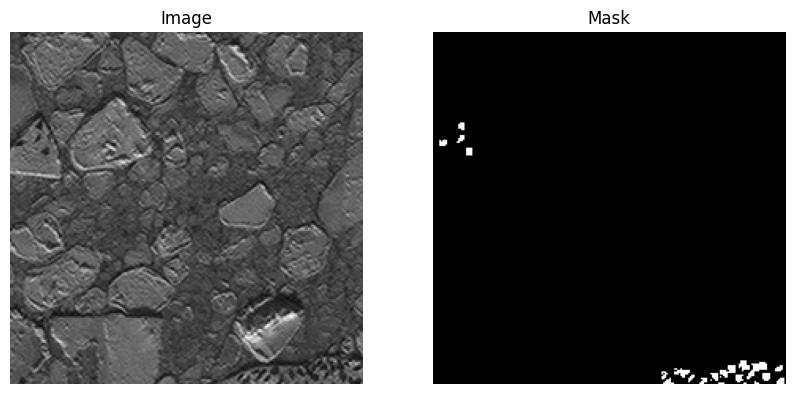

STD: 0.23736467957496643, Mean: -0.6752426624298096, Min: -1.4210219383239746, Max: 0.8823530673980713
Image shape: torch.Size([1, 224, 224])


In [17]:
image, mask = train_dataset[125]
channels = image.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(denormalize(image).permute(1,2,0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1,2,0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

print(f'STD: {torch.std(image)}, Mean: {torch.mean(image)}, Min: {torch.min(image)}, Max: {torch.max(image)}')
print(f'Image shape: {image.shape}')

### U-Net
Initializing the pretrained U-Net model using the segmentation_models.pytorch library (smp).
Source:https://smp.readthedocs.io/en/latest/models.html#unet

In [18]:
model = smp.Unet(
    encoder_name="efficientnet-b7",         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',             # imagenet if using pretrained, None is no pretraining
    in_channels=channels,                   # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=channels                        # model output channels (number of classes in your dataset)

)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 440MB/s]


### The training loop
Setting up the training loop with the following parameters:


*   Learning rate : 0.003
*   Number of epochs : 30
*   Loss function : Tversky loss (alpha and beta defined in the function)
*   Optimizer : Adam
*   Scheduler : ReduceLROnPlateau (factor : 0.1, patience : 5)

Plot the training and validation loss at the end.






/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/2, Train Loss: 0.7729, Val Loss: 0.9964, Epoch time:  41.67s, LR: 0.003
Epoch 2/2, Train Loss: 0.4491, Val Loss: 0.9946, Epoch time:  41.51s, LR: 0.003
Best epoch is 2, with a validation loss of 0.9946488773121553


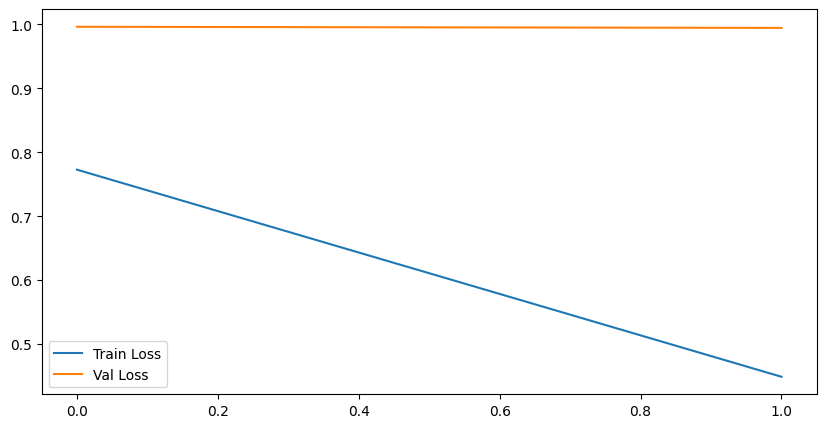

In [19]:
learning_rate = 0.003
num_epochs = 30

criterion = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training and validation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

best_loss = 10000000
best_model = 0
best_epoch = 0

for epoch in range(num_epochs):
    start_time = time.time() #start time for epoch

    model.train()
    train_loss = 0.0
    tr_all_outputs = []
    tr_all_masks = []
    for image, mask in train_loader:
        image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
        outputs = torch.sigmoid(outputs)
        outputs= outputs.cpu().detach()
        tr_all_outputs.append(outputs)
        tr_all_masks.append(mask.cpu().detach())
        train_loss += loss.item()


    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_all_outputs = []
    val_all_masks = []
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
            outputs = model(image)
            loss = criterion(outputs, mask)
            outputs = torch.sigmoid(outputs)
            outputs= outputs.cpu().detach()
            val_all_outputs.append(outputs)
            val_all_masks.append(mask.cpu().detach())
            val_loss += loss.item()


    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model
      best_epoch = epoch+1


    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch time: {epoch_time: .2f}s, LR: {get_lr(optimizer)}')
print(f"Best epoch is {best_epoch}, with a validation loss of {best_loss}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

### Evaluate the trained model
Show pixel accuracy, dice, precision, recall and specificity to evaluate the model metrics.
Plot the precision-recall curve.

+----------------+------------+
| Metric         |      Value |
+================+============+
| Pixel Accuracy | 0.438219   |
+----------------+------------+
| Dice           | 0.0035081  |
+----------------+------------+
| Precision      | 0.00175759 |
+----------------+------------+
| Recall         | 0.871777   |
+----------------+------------+
| Specificity    | 0.437727   |
+----------------+------------+


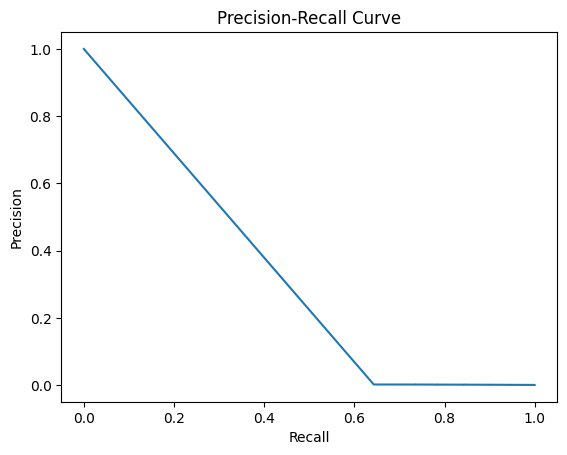

In [20]:
# Evaluate the model and collect outputs and masks
best_model.eval()

te_all_outputs = []
te_all_masks = []

for image, mask in test_loader:
    image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
    outputs = best_model(image)

    outputs = torch.sigmoid(outputs)  # Assuming the output is a logit
    outputs = outputs.cpu().detach()

    te_all_outputs.append(outputs)
    te_all_masks.append(mask.cpu().detach())


metrics(te_all_outputs, te_all_masks)

te_all_outputs = torch.cat(te_all_outputs).view(-1)
te_all_masks = torch.cat(te_all_masks).view(-1)


te_all_outputs_np = te_all_outputs.numpy()
te_all_masks_np = te_all_masks.numpy()

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(te_all_masks_np, te_all_outputs_np)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, marker=' ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Visualize test images
Plot all the test images with their corresponding true and predicted mask for visual evaluation.
Reduce the number of visualized test data if the number of test images is high.


In [ ]:
# Index of the image you want to visualize
for i in range(len(test_dataset)):

# Set visualization variables
  image, mask = test_dataset[i]
  image = image.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension
  mask = mask.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension

  best_model.eval()
  with torch.no_grad():
    pred = best_model(image)

  pred = torch.sigmoid(pred).squeeze(0).cpu().numpy()  # Convert prediction to numpy array
  pred_print = (pred == 1).astype(float)

  fig, axes = plt.subplots(1, 3, figsize=(6, 2))

  image_np = denormalize(image.squeeze()).cpu().numpy()
  axes[0].imshow(image_np.transpose(1, 2, 0), cmap = 'gray')  # Use grayscale if single channel
  axes[0].set_title('Image')
  axes[0].axis('off')

  mask_np = mask.squeeze().cpu().numpy()
  #print(f'True mask shape for imshow: {mask_np.shape}')
  if channels != 1:
    axes[1].imshow(mask_np.transpose(1, 2, 0), cmap = 'gray')  # Convert mask to numpy array
  else:
    axes[1].imshow(mask_np, cmap = 'gray')

  axes[1].set_title('True Mask')
  axes[1].axis('off')

  #print(f'Predicted mask shape for imshow: {pred_print.shape}')
  axes[2].imshow(pred_print.transpose(1, 2, 0), cmap = 'gray')  # Use grayscale colormap for binary mask
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

plt.show()

### Saving the model weigths
Save the weights and use them in post-processing.

In [30]:
# Run this code if your model is good, you can save the weights to drive:
model_name = "Test"
torch.save(best_model, model_output_path + model_name)
print(f'Model saved to {model_output_path + model_name}')

Model saved to /content/drive/MyDrive/TheNavySeals/data/2_deep_learning/2b_output_model/Test
